In [1]:
import datetime
import smtplib
from email.mime.text import MIMEText
import QUANTAXIS as QA

try:
    assert QA.__version__ >= '1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings
import re
read_dictionary = np.load('/media/sf_GIT/vest/liutong.npy', allow_pickle=True).item()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_finance as mpf
index = 'datetime'
formate = '%Y-%m-%dT%H:%M:%S'
dayindex = 'date'
dayformate = '%Y-%m-%d'
startday='2018-01-01'

pw=0.47  #backtest win ratio
rw=1.15 #sell when got 15% increase
rl=0.97 #end if loss 0.03 of holdings
def percSet(pw,rw,rl):
    #kelly rule of holdings
    return (pw/rl)-(1-pw)/rw
#percSet(pw,rw,rl)


def initData(sample):
    sample['EMA13'] = QA.EMA(sample.close, 13)
    #sample['EMA26'] = QA.EMA(sample.close,26)
    sample['MA64'] = QA.MA(sample.close,64)
    sample['MA256'] = QA.MA(sample.close,256)
    pp_array = [x for x in sample.close]
    forceweight =[]
    force = [0]
    for m,n in zip(pp_array[:-1],pp_array[1:]):
        force.append(n-m)
        #print (n-m)
    #only for online data. is sample.vol, datat
    volumn = [x for x in sample.volume]
    for x,y in zip(force,volumn):
        #print("{0} and {1}".format(x,y))
        forceweight.append(x*y)

    sample['FORCE']=forceweight
    sample['FCEMA2']=QA.EMA(sample.FORCE,2)
    sample['FCEMA13']=QA.EMA(sample.FORCE,13)
    #print(sample)
    rate = 0.015
    sample['EMA12'] = QA.EMA(sample.close, 12)
    sample['EMA5']=QA.EMA(sample.close,5)
    #sample['MA64']=QA.MA(sample.close,64)
    #sample['MA256']=QA.MA(sample.close,256)
    sample['EMA20']=QA.EMA(sample.close,20)
    sample['k1'] = 0.618 * QA.HHV(sample.high, 256) + 0.382 * QA.LLV(sample.low, 256)
    sample['k2'] = 0.5 * QA.HHV(sample.high, 256) + 0.5 * QA.LLV(sample.low, 256)
    sample['k3'] = 0.382 * QA.HHV(sample.high, 256) + 0.618 * QA.LLV(sample.low, 256)
    sample['EMA30']=QA.EMA(sample.close,30)
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    sample['up'] = sample.EMA13 * (1 + rate)
    sample['down'] = sample.EMA13 * (1 - rate)
    sample['EMA26'] = QA.EMA(sample.close, 26)
    sample['MACDQ'] = sample['EMA12'] - sample['EMA26']
    sample['MACDSIG'] = QA.EMA(sample['MACDQ'], 9)
    sample['MACDBlock'] = sample['MACDQ'] - sample['MACDSIG']
    sample['VolumeEMA'] = QA.EMA(sample.volume, 5)
    #sample['VolumeEMA'] = QA.EMA(sample.vol, 5)

    #trend block
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    N = 15
    sample['nhigh']=pd_rolling_max(sample.high,window=N)
    expanmax = pd_expanding_max(sample.close)
    sample['nhigh'].fillna(value=expanmax,inplace=True)

    from abupy import pd_rolling_min, pd_expanding_min
    sample['nlow']=pd_rolling_min(sample.low,window=N)
    expanmin = pd_expanding_min(sample.close)
    sample['nlow'].fillna(value=expanmin,inplace = True)



    sroc = []
    for i in range(sample.shape[0]):
        if (i - 21 > 0 and sample.iloc[i].EMA13 != None and sample.iloc[i - 21].EMA13 != None):
            # print(sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)
            sroc.append((sample.iloc[i].EMA13 / sample.iloc[i - 21].EMA13) * 100)
        else:
            sroc.append(100)
    sample['SROC'] = sroc
    return sample


def MACACalculate(sample):
    rate = 0.015
    sample['EMA12'] = QA.EMA(sample.close, 12)
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    sample['up'] = sample.EMA13 * (1 + rate)
    sample['down'] = sample.EMA13 * (1 - rate)
    sample['EMA26'] = QA.EMA(sample.close, 26)
    sample['MACDQ'] = sample['EMA12'] - sample['EMA26']
    sample['MACDSIG'] = QA.EMA(sample['MACDQ'], 9)
    sample['MACDBlock'] = sample['MACDQ'] - sample['MACDSIG']
    sample['VolumeEMA'] = QA.EMA(sample.volume, 5)
    sroc = []
    for i in range(sample.shape[0]):
        if (i - 21 > 0 and sample.iloc[i].EMA13 != None and sample.iloc[i - 21].EMA13 != None):
            # print(sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)
            sroc.append((sample.iloc[i].EMA13 / sample.iloc[i - 21].EMA13) * 100)
        else:
            sroc.append(100)
    sample['SROC'] = sroc
    size = sample.shape[0]
    single = [0]
    for i in range(sample.shape[0]):
        if (sample.MACDBlock[i - 1] < 0 and sample.MACDBlock[i] >= 0 and i - 1 >= 0):
            print(sample.index.get_level_values('date')[i])
            single.append(1)
        elif (sample.MACDBlock[i - 1] >= 0 and sample.MACDBlock[i] < 0 and i):
            single.append(3)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if (single[i] == 1 and i + 3 < size):
            single[i + 3] = 3
    single.pop()
    sample['single'] = single

    return sample


def candlestruct(sample):
    import matplotlib.dates as mpd
    quotes = []
    pydate_array = sample.index.get_level_values('date').to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array)
    # date_only_series = pd.Series(date_only_array)
    N = sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)
    for i in range(len(sample)):
        li = []
        # datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
        # datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d'))
        datef = ind[i]  # 日期转换成float days
        open_p = sample.open[i]
        close_p = sample.close[i]
        high_p = sample.high[i]
        low_p = sample.low[i]
        li = [datef, open_p, close_p, high_p, low_p]
        t = tuple(li)
        quotes.append(t)
    return quotes


def MACDPLOT(sample):
    quotes = candlestruct(sample)
    N = sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return sample.index.get_level_values('date')[thisind].strftime('%Y-%m-%d')

    fig = plt.figure()
    fig.set_size_inches(20.5, 12.5)
    # plt.xlabel('Trading Day')
    # plt.ylabel('MACD EMA')
    ax2 = fig.add_subplot(4, 1, 1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')

    # fig,ax=plt.subplots()
    # mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    # ax2.xaxis_date()
    # plt.setp(plt.gca().get_xticklabels(),rotation=30)
    # ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.plot(ind, sample.up, 'r-')
    ax2.plot(ind, sample.down, 'b-')
    ax2.grid(True)
    # t.legend()
    fig.autofmt_xdate()

    ax4 = fig.add_subplot(4, 1, 2, sharex=ax2)
    ax4.set_title("EMA13/SROC21", fontsize='xx-large', fontweight='bold')
    # ax1 = ax2.twinx()   #not working like it's
    ax4.plot(ind, sample.SROC, 'r-')
    ax4.grid(True)
    ax4.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    ax3 = fig.add_subplot(4, 1, 4, sharex=ax2)
    ax3.set_title("volume EMA", fontsize='xx-large', fontweight='bold')
    # ax1 = ax2.twinx()   #not working like it's
    ax3.bar(ind, sample.volume)
    ax3.plot(ind, sample.VolumeEMA, 'r-')
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    ax1 = fig.add_subplot(4, 1, 3, sharex=ax2)
    ax1.set_title('macd', fontsize='xx-large', fontweight='bold')
    ax1.grid(True)
    ax1.plot(ind, sample.MACDQ, 'r-', marker='*')
    ax1.plot(ind, sample.MACDSIG, 'o-')
    ax1.bar(ind, sample.MACDBlock)
    ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    # ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    fig.autofmt_xdate()
    plt.legend()

    code = sample.index.get_level_values('code')[0]

    plt.savefig('/home/mildone/monitor/' + 'Trend' + code + '.png')
    plt.show()
    plt.close()


def amountAnalyse(buydata):
    """
    @buydata as pdDataFrame
    e.g. buydata = QA.QA_fetch_get_stock_transaction_realtime('pytdx','600797') get current day's transaction
    e.g. data1=QA.QAFetch.QATdx.QA_fetch_get_stock_transaction('600797','2019-01-01','2019-04-11') get transaction among period of time

    """
    sellone = buydata[buydata['buyorsell'] == 1]
    sellone['amount'] = sellone['price'] * sellone['vol']
    sellone.sort_values("vol", inplace=True, ascending=False)

    buyone = buydata[buydata['buyorsell'] == 0]
    buyone['amount'] = buyone['price'] * buyone['vol']
    buyone.sort_values("vol", inplace=True, ascending=False)
    # print("Top buyer vol")
    # buyone[buyone['vol']>10]
    print("Top Seller vol")
    sellone.head(100)


def getStocklist():
    """
    get all stock as list
    usage as:
    QA.QA_util_log_info('GET STOCK LIST')
    stocks=getStocklist()
    """
    data = QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')
    stock = data['code'].index
    stocklist = []
    for code in stock:
        stocklist.append(code[0])
    return stocklist


def loadLocalData(stocks, start_date='2018-03-15', end_date='2019-09-07'):
    """
    data() as pdDataFrame
    stocks could be list of all the stock or some. if you pass single one e.g. 000001 it will get one only
    to get dedicated stock, using below method, and notice stockp() will be dataFrame
    stockp = data.select_code(stock)


    """
    QA.QA_util_log_info('load data from local DB')
    data = QA.QA_fetch_stock_day_adv(stocks, start_date, end_date)
    return data


def loadFromCopy(file):
    """
    loaddata from file copy
    """
    return pd.DataFrame(pd.read_csv(file))


def calAngle(df):
    """
    trend angle based on provided dataframe
    """
    return ABuRegUtil.calc_regress_deg(df.close.values, show=False)


def getData(df, code):
    """
    split data per code from all market data
    """
    return df[df.code == code].reset_index(drop=True)


def trendBreak(pdDataFrame):
    """
    trendBreak based on provdied market data
    """

    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 20
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 15
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    # print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    # 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有
    buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
    kl_pd.loc[buy_index, 'signal'] = 1

    # 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
    sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
    kl_pd.loc[sell_index, 'signal'] = 0

    # kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))
    #plt.show()

    """
        将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
        这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
        才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
    """
    kl_pd['keep'] = kl_pd['signal'].shift(1)
    kl_pd['keep'].fillna(method='ffill', inplace=True)
    return kl_pd

    # 计算基准收益
    # kl_pd['benchmark_profit'] = np.log(
    # kl_pd['close'] / kl_pd['close'].shift(1))

    # 计算使用趋势突破策略的收益
    # kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

    # 可视化收益的情况对比
    # kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
    #                                                      figsize=(
    #                                                          14, 7))
    # plt.show()
    # kl_pd[['n2_low','n1_high','close']].plot(grid=True,figsize=(14,7))
    # kl_pd.close.plot(grid=True,figsize=(14.7))
    # plt.show()






def init_change(df):
    # change first (d[i].close-d[i-1].close)/d[i-1].close
    pp_array = [float(close) for close in df.close]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    df['change'] = change
    # amplitude (d[i].high-d[i].low)/d[i-1].close)
    amp_arry = [float(amp) for amp in (df.high - df.low)]
    amp_temp = [(price1, price2) for price1, price2 in zip(amp_arry[:-1], pp_array[1:])]
    amplitude = list(map(lambda pp: reduce(lambda a, b: round(a / b, 3), pp), amp_temp))
    amplitude.insert(0, 0)
    df['amplitude'] = amplitude
    # sratio = QA.QA_fetch_get_stock_info(df.index.get_level_values('code')[0]).liutongguben[0]
    sratio = read_dictionary[df.index.get_level_values('code')[0]]
    df['SR'] = df['volume'] / sratio * 100


def init_trend(df, period=7):
    """
    period can be set based on situation.
    detect the angle change form negative to positive
    """
    trend = []
    ratio = []
    for i in range(0, df.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i - period + 1:i + 1]))
            ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    df['trend'] = trend
    df['amountRatio'] = ratio

def init_trendMACD(df, period=7):
    """
    period can be set based on situation.
    detect the angle change form negative to positive
    """
    trend = []
    ratio = []
    for i in range(0, df.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i - period + 1:i + 1]))
            ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    df['trend'] = trend
    df['amountRatio'] = ratio
    return df

"""

def trendSingle(df):

    buydate=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude<0.07 and df.iloc[i].change<0.03 
          and df.iloc[i].change>0.01):
            buydate.append((i,df.iloc[i].date))
    return buydate
"""


def trendSingle(df, period=7):
    """
    @paramater dataframe
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. change (0.1~0.3)
    3.

    """
    # df['trend']=0
    # df['amountRatio']=0
    # trend=0
    # amountRatio=0
    keep = 5
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")
    # single.insert(0,0)
    single.pop()
    # print(single)
    size = len(single)
    # for simple purpose, set last (Keep) as 0,simple take 3 days as holding max

    # print("checking operation single")
    for i in range(0, size - 5):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j + 1].change > 0 and df.iloc[j + 1].close < bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j + 2].close < bar) or
                    (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open)):
                single[j + 2] = 0

            else:
                single[j + 2] = 3
                continue
            if ((df.iloc[j + 3].change > 0 and df.iloc[j + 3].close < bar)
                    or (df.iloc[j + 3].change < 0 and df.iloc[j + 3].close > df.iloc[i].open)):
                single[j + 3] = 0
            else:
                single[j + 3] = 3
                continue
            if ((df.iloc[j + 4].change > 0 and df.iloc[j + 4].close < bar)
                    or (df.iloc[j + 4].change < 0 and df.iloc[j + 4].close > df.iloc[i].open)):
                single[j + 4] = 0
            else:
                single[j + 4] = 3
                continue
            single[j + 5] = 3

    single[-5:] = [0, 0, 0, 0, 0]

    df['single'] = single
    # df['single']=df['keep'].shift(1)
    # df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df

def nineTurn(sample, period = 7):
    sample['highEMAS25'] = QA.EMA(sample.high, 25)
    sample['lowEMAS25'] = QA.EMA(sample.low, 25)
    sample['Stunel'] = sample.highEMAS25 - sample.lowEMAS25
    sample['highEMAL90'] = QA.EMA(sample.high, 90)
    sample['lowEMAL90'] = QA.EMA(sample.low, 90)
    single = [0 for _ in range(13)]
    N = sample.shape[0]
    for i in range(13, N):
        Raise = 1
        Down = 1
        # print('round {}'.format(i))
        for j in range(i - 8, i + 1):
            # print('round {}, index {}'.format(i,j))
            if (sample.close[j] > sample.close[j - 4]):
                Raise = Raise * 1
                Down = Down * 0
            else:
                Raise = Raise * 0
                Down = Down * 1
        # if(Raise and max(sample.close[i],sample.close[i-1])>max(sample.close[i-2],sample.close[i-3])):
        # if (Raise and sample.close[i] > sample.close[i - 2]):
        if (Down and sample.close[i]<sample.lowEMAS25[i]):
            # for n in range(i - 9, i):
            single.append(1)
        else:
            single.append(0)
    for i in range(len(single)):
        if (i+5 < len(single) and single[i]==1):
            single[i+5] = 3
    sample['single'] = single

    return sample


def trendSingleNew(df, period=7):
    # df['trend']=0
    # df['amountRatio']=0
    # trend=0
    # amountRatio=0
    # keep = ３
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")
    # single.insert(0,0)
    single.pop()
    # print(single)
    size = len(single)
    # for simple purpose, set last (Keep) as 0,simple take 3 days as holding max

    # print("checking operation single")
    for i in range(0, size - 3):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j + 1].change > 0 and df.iloc[j + 1].close < bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j + 2].close < bar) or
                    (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open)):
                single[j + 2] = 0

            else:
                single[j + 2] = 3
                continue

            single[j + 3] = 3

    single[-3:] = [0, 0, 0]

    df['single'] = single
    # df['single']=df['keep'].shift(1)
    # df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df


def ana(df):
    # df = loadLocalData(code,'2014-01-01','2019-09-30')
    # df = df.to_qfq()
    init_change(df)
    init_trend(df)
    if (1.5 > df.iloc[-1].amountRatio > 1 and df.iloc[-1].trend > 1 and df.iloc[-1].amplitude > 0.05
            and 0.01 < df.iloc[-1].change < 0.03 and df.iloc[-1].SR < 0.05):
        return True
    else:
        return False


def detect(df):
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")

    # single.insert(0,0)
    single.pop()
    if (single[-1] == 1):
        return True
    else:
        return False


def generateplot(code):
    import datetime
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    sample = loadLocalData(code, '2019-08-01', endtime)
    sample = sample.to_qfq()
    sampleData = sample.select_code(code)
    MACACalculate(sampleData.data)
    MACDPLOT(sampleData.data)


def gitAction(candidate):
    from git import Repo
    r = Repo('/home/mildone/monitor')
    commitfile = [r'/home/mildone/monitor/result.log', r'/home/mildone/monitor/data.csv']

    prefix = '/home/mildone/monitor/'
    if (len(candidate) > 0):
        for i in range(len(candidate)):
            generateplot(candidate[i])
            pltfile = prefix + 'Trend' + candidate[i] + '.png'
            commitfile.append(pltfile)
    r.index.add(commitfile)
    cur = datetime.datetime.now()
    msg = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day) + ' commit'
    r.index.commit(msg)
    r.remote().push('master')


def dianostic(code):
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    daydata = QA.QA_fetch_stock_day_adv(code, '2019-04-01', endtime)
    # MINMACACalculate(mindata.data)
    # MINMACDPLOT(mindata.data,index,formate)
    MACACalculate(daydata.data)
    MACDPLOT(daydata.data[:])

def EMAOP(sample):
    period=5
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    pp_array = [float(optimism) for optimism in sample.optimism]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    trend = []

    for i in range(0, sample.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(sample.iloc[:period]))
            #ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(sample.iloc[i - period + 1:i + 1]))
            #ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    sample['trend'] = trend


    size = sample.shape[0]
    single = [0]
    for i in range(sample.shape[0]):
        if (sample.pessmist[i - 1] < 0 and sample.pessmist[i] >= 0 and i - 1 >= 0
                and sample.trend[i]>sample.trend[i-1] and sample.trend[i]>0):
            #print(sample.index.get_level_values('date')[i])
            single.append(1)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if (single[i] == 1 and i + 3 < size):
            single[i + 3] = 3
    single.pop()
    sample['single'] = single

    return sample

def winRatio(Account):
    #input as Account after backtest
    #output is wining ratio of all the trade
    his = Account.history_table
    vest = {}
    win = 0
    loss = 0
    for i in range(his.shape[0]):
        if his.code[i] in vest:
            if (his.price[i] > vest[his.code[i]]):
                win += 1
            elif (his.price[i] < vest[his.code[i]]):
                loss += 1
            del vest[his.code[i]]
        else:
            vest[his.code[i]] = his.price[i]
    print('win {}, loss {}'.format(win, loss))
    return win/(win + loss)
def MACD_JCSC(dataframe, SHORT=12, LONG=26, M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE = dataframe.close
    DIFF = QA.EMA(CLOSE, SHORT) - QA.EMA(CLOSE, LONG)
    DEA = QA.EMA(DIFF, M)
    MACD = 2*(DIFF-DEA)

    CROSS_JC = QA.CROSS(DIFF, DEA)
    CROSS_SC = QA.CROSS(DEA, DIFF)
    ZERO = 0

    SC = np.where(CROSS_SC == 1, 3, 0)
    m = np.where(CROSS_JC == 1, 1, SC)

    #single = m[:-1].tolist()
    #single.insert(0, 0)
    #dataframe['single'] = single

    dataframe['single'] = m.tolist()

    return dataframe


def doubleAvg(sample, short=5, long=15):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    sample['short']=QA.EMA(sample.close,short)
    sample['long']=QA.EMA(sample.close,long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    single = m[:-1].tolist()
    single.insert(0, 0)
    sample['single'] = single
    #sample['single']=m

    return sample
def doubleAvgmin(dd, short=5, long=15,freq='60min'):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    start = dd.index.get_level_values('date')[0].strftime('%Y-%m-%d')
    end = dd.index.get_level_values('date')[-1].strftime('%Y-%m-%d')
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0],start,end, frequence= freq)
    sample =mindata.data
    #print(sample)
    sample['short']=QA.EMA(sample.close,short)
    sample['long']=QA.EMA(sample.close,long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    #single = m[:-1].tolist()
    #single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = []
    for i in range(0, len(dd)):
        temp = sample[sample.index.get_level_values(uti.index).strftime(uti.dayformate)==dd.index.get_level_values(uti.dayindex)[i].strftime(uti.dayformate)]
        temp['single'].cumsum(axis=0)
        if(temp.single[-2]>=4):
            sig.append(0)
        else:
            sig.append(temp.single[-2]) 
    
    try:
        dd['single'] = sig
    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single']=0

    return dd






/root/anaconda3/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
sample = QA.QA_fetch_stock_day_adv('000977','2020-01-01','2020-06-08').data

In [3]:
import quant.weekTrend as wt

In [4]:
wf = wt.weekDF(sample)


In [5]:
wf

,date,open,high,low,close,volume,amount
0,2020-01-05,30.38,31.65,30.07,31.63,707947.0,2.1937e+09
1,2020-01-12,31.50,32.25,29.80,31.92,2177494.0,6.7935e+09
2,2020-01-19,31.92,33.92,31.53,33.50,2188423.0,7.1454e+09
3,2020-01-26,33.50,36.66,33.21,34.13,2058187.0,7.2081e+09
4,2020-02-02,NaN,NaN,NaN,NaN,0.0,0.0000e+00
5,2020-02-09,30.72,43.77,30.72,43.77,4337686.0,1.6423e+10
6,2020-02-16,44.78,50.26,41.00,47.39,4480588.0,2.0442e+10
7,2020-02-23,47.39,49.49,45.70,48.15,3826055.0,1.8302e+10
8,2020-03-01,47.00,49.91,41.90,42.05,5138204.0,2.4181e+10
9,2020-03-08,42.99,47.66,42.01,43.13,3124649.0,1.3840e+10


In [ ]:
from abupy import ABuRegUtil
ABuRegUtil.calc_regress_deg(dd.close.values[-15:],show=True)

****************************************************************************************************
loading data
****************************************************************************************************
init account


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2019-01-10 600476   NaN   NaN  NaN    NaN     NaN  4.2604e+07  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-01-10 00:00:00 buy 600476
trade_time                None
code                    000810
name                      None
towards                      1
trade_amount                 0
trade_price                  0
trade_money                  0
trade_id        Trade_pzg19ecZ
Name: (ECAP, Order_3Shm0EFj), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                     open    high     low   close      volume      amount  \
date       code                                                             
2019-01-15 000810  5.8782  5.9872  5.7989  5.9773  49958.7982  2.9655e+07   

                      adj  single  
date       code                    
2019-01-15 000810  0.9913       1  
generate order for 000810
QAACCOUNT ==> receive deal  Time 2019-01-15 00:00:00/ Code:000810/ Price:5.88/ TOWARDS:1/ Amounts:3300
*************************************

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-01-24 00:00:00 buy 600745
trade_time      2019-01-15 00:00:00
code                         000810
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                1.94e+04
trade_id             Trade_Tofw0Rdh
Name: (ECAP, Order_AFdKEQrn), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                     open    high    low   close       volume      amount  \
date       code                                                             
2019-01-25 002241  6.8661  6.9945  6.787  6.8661  250241.2372  1.7247e+08   

                      adj  single  
date       code                    
2019-01-25 002241  0.9879       1  
generate order for 002241
QAACCOUNT ==> receive deal  Time 2019-01-25 00:00:00/ Code:002241/ Price:6.87/ TOWARDS:1/ Amounts:19

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


****************************************************************************************************
2019-02-22 00:00:00 buy 600745
trade_time      2019-01-29 00:00:00
code                         002241
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                       5
trade_id             Trade_WyZSth2k
Name: (ECAP, Order_jheXG18a), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                     open    high    low   close      volume      amount  \
date       code                                                            
2019-03-08 002241  8.7925  9.8891  8.674  9.8891  1.5259e+06  1.4584e+09   

                      adj  single  
date       code                    
2019-03-08 002241  0.9879       1  
generate order for 002241
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:002241/ Price:8.79/ TOWARDS:1/ Amounts:1000
***************************************

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-04-12 00:00:00 buy 600476
trade_time      2019-04-04 00:00:00
code                         002241
name                           None
towards                          -1
trade_amount                      0
trade_price                       0
trade_money               1.036e+04
trade_id             Trade_CVsk4gfR
Name: (ECAP, Order_8mcnZa7i), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                     open     high      low    close       volume      amount  \
date       code                                                                 
2019-04-24 000977  24.213  26.3991  23.8533  26.3991  819232.7841  2.0787e+09   

                      adj  single  
date       code                    
2019-04-24 000977  0.9224       1  
generate order for 000977
QAACCOUNT ==> receive deal  Time 2019-04-24 00:00:00/ Code:000977/ Price:24.21/ TOWARDS:

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-05-10 00:00:00 buy 600476
trade_time      2019-05-10 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                    8806
trade_id             Trade_nzEF84NH
Name: (ECAP, Order_wMtQs7p5), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                     open     high    low   close      volume      amount  \
date       code                                                             
2019-05-17 000810  9.5557  10.3091  9.189  9.8234  314619.774  3.0611e+08   

                      adj  single  
date       code                    
2019-05-17 000810  0.9913       1  
generate order for 000810
QAACCOUNT ==> receive deal  Time 2019-05-17 00:00:00/ Code:000810/ Price:9.56/ TOWARDS:1/ Amounts:80

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-07-01 00:00:00 buy 600476
trade_time      2019-06-27 00:00:00
code                         000810
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               1.781e+04
trade_id             Trade_Rk8Bq1mb
Name: (ECAP, Order_D91hEqmO), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2019-07-05 600745   NaN   NaN  NaN    NaN     NaN  2.6573e+08  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-07-05 00:00:00 buy 600745
trade_time      2019-06-27 00:00:00
code                         000810
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               1.781e+04
trade_id             Trade_nYxJzXDL
Name: (ECAP, Order_D91hEqmO), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                   open  high   low  close    volume      amount  adj  single
date       code                                                              
2019-07-08 002241  9.55  9.69  9.15   9.56  544874.0  5.1504e+08  1.0       1
generate order for 002241
QAACCOUNT ==> receive deal  Time 2019-07-08 00:00:00/ Code:002241/ Price:9.55/ TOWARDS:1/ Amounts:1300
****************************************************************************************************
20

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-07-15 00:00:00 buy 600745
trade_time      2019-07-11 00:00:00
code                         002241
name                           None
towards                          -1
trade_amount                      0
trade_price                       0
trade_money               4.395e+04
trade_id             Trade_ETe5YHbs
Name: (ECAP, Order_1yuqlr4I), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-19 00:00:00 sell 000810
QAACCOUNT ==> receive deal  Time 2019-07-19 00:00:00/ Code:000810/ Price:9.1/ TOWARDS:-1/ Amounts:2000
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2019-08-12 600745   NaN   NaN  NaN    NaN     NaN  4.4293e+08  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-08-12 00:00:00 buy 600745
trade_time      2019-07-19 00:00:00
code                         000810
name                           None
towards                          -1
trade_amount                      0
trade_price                       0
trade_money               1.822e+04
trade_id             Trade_Z9oziLkx
Name: (ECAP, Order_p3Ixr2yv), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                      open     high      low    close       volume  \
date       code                                                      
2019-08-15 000977  18.0096  19.0636  17.9079  19.0544  379448.9313   

                       amount     adj  single  
date       code                                
2019-08-15 000977  7.0589e+08  0.9245       1  
generate order for 000977
QAACCOUNT ==> receive deal  Time 2019-08-15 00:00:00/ Code:000977/ Price:18.01/ TOWAR

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-08-16 00:00:00 buy 600745
trade_time      2019-08-15 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               2.882e+04
trade_id             Trade_4QD815zy
Name: (ECAP, Order_nG2zfa0j), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2019-09-19 600745   NaN   NaN  NaN    NaN     NaN  2.3879e+09  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-09-19 00:00:00 buy 600745
trade_time      2019-08-15 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               2.882e+04
trade_id             Trade_l1uwhTSQ
Name: (ECAP, Order_nG2zfa0j), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                     open    high     low   close       volume      amount  \
date       code                                                              
2019-09-20 000810  9.2088  9.3079  9.0105  9.2484  107229.5259  9.8605e+07   

                      adj  single  
date       code                    
2019-09-20 000810  0.9913       1  
generate order for 000810
QAACCOUNT ==> receive deal  Time 2019-09-20 00:00:00/ Code:000810/ Price:9.21/ TOWARDS:1/ Amounts

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-10-10 00:00:00 buy 600745
trade_time      2019-09-20 00:00:00
code                         000810
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               1.934e+04
trade_id             Trade_ACpvJQRF
Name: (ECAP, Order_wDdvRBhW), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-10-15 00:00:00 sell 000810
QAACCOUNT ==> receive deal  Time 2019-10-15 00:00:00/ Code:000810/ Price:9.8/ TOWARDS:-1/ Amounts:2100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-10-15 00:00:00 sell 000977
QAACCOUNT ==> receive deal  Time 2019-10-15 00:00:00/ Code:000977/ Price:23.88/ TOWARDS:-1/ Amoun

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-11-13 00:00:00 buy 600745
trade_time      2019-10-15 00:00:00
code                         000977
name                           None
towards                          -1
trade_amount                      0
trade_price                       0
trade_money               3.825e+04
trade_id             Trade_ZBrFMIiw
Name: (ECAP, Order_QxsniE7F), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                    open   high    low  close    volume      amount  adj  \
date       code                                                            
2019-11-14 000810  10.41  10.86  10.32  10.77  195511.0  2.0887e+08  1.0   

                   single  
date       code            
2019-11-14 000810       1  
generate order for 000810
QAACCOUNT ==> receive deal  Time 2019-11-14 00:00:00/ Code:000810/ Price:10.41/ TOWARDS:1/ Amounts:3100
***********************

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-11-19 00:00:00 buy 600476
trade_time      2019-11-14 00:00:00
code                         000810
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               3.228e+04
trade_id             Trade_meCx46qF
Name: (ECAP, Order_UIc6DhAa), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                    open   high   low  close    volume      amount  adj  \
date       code                                                           
2019-11-28 000810  10.28  10.54  10.2  10.39  139138.0  1.4488e+08  1.0   

                   single  
date       code            
2019-11-28 000810       1  
generate order for 000810
QAACCOUNT ==> receive deal  Time 2019-11-28 00:00:00/ Code:000810/ Price:10.28/ TOWARDS:1/ Amounts:2100
**************************

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-11-28 00:00:00 buy 600476
trade_time      2019-11-28 00:00:00
code                         000810
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money               2.159e+04
trade_id             Trade_87UmVdZy
Name: (ECAP, Order_T8R37MQZ), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-12-03 00:00:00 sell 000810
QAACCOUNT ==> receive deal  Time 2019-12-03 00:00:00/ Code:000810/ Price:10.43/ TOWARDS:-1/ Amounts:5200
                      open    high      low   close       volume      amount  \
date       code                                                                
2019-12-09 000977  27.6431  29.446  27.2733  29.446  733642.5859  2.

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


****************************************************************************************************
2020-01-09 00:00:00 buy 600745
trade_time      2019-12-26 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                       5
trade_id             Trade_HVUwsAcR
Name: (ECAP, Order_oQwOry81), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                    open  high   low  close    volume      amount  adj  single
date       code                                                               
2020-01-14 000810  14.34  15.1  14.1  14.93  405727.0  5.9108e+08  1.0       1
generate order for 000810
QAACCOUNT ==> receive deal  Time 2020-01-14 00:00:00/ Code:000810/ Price:14.34/ TOWARDS:1/ Amounts:1000
****************************************************************************************************
2020-01-14 00:00:00 buy 000810
trade_

QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


****************************************************************************************************
2020-02-10 00:00:00 buy 600476
trade_time      2020-01-23 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                       5
trade_id             Trade_807jIHZn
Name: (ECAP, Order_zPAl7NjD), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2020-04-02 600745   NaN   NaN  NaN    NaN     NaN  2.8754e+09  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


****************************************************************************************************
2020-04-02 00:00:00 buy 600745
trade_time      2020-01-23 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                       5
trade_id             Trade_ejGXNyzp
Name: (ECAP, Order_zPAl7NjD), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2020-04-20 600476   NaN   NaN  NaN    NaN     NaN  1.9238e+07  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


****************************************************************************************************
2020-04-20 00:00:00 buy 600476
trade_time      2020-01-23 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                       5
trade_id             Trade_PleO0DdQ
Name: (ECAP, Order_zPAl7NjD), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
                   open  high  low  close  volume      amount  adj  single
date       code                                                           
2020-04-28 002241   NaN   NaN  NaN    NaN     NaN  1.6556e+09  NaN       1


QUANTAXIS>> MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'
MARKET ENGINE ERROR: float() argument must be a string or a number, not 'NoneType'


****************************************************************************************************
2020-04-28 00:00:00 buy 002241
trade_time      2020-01-23 00:00:00
code                         000977
name                           None
towards                           1
trade_amount                      0
trade_price                       0
trade_money                       5
trade_id             Trade_Mg9ChSkY
Name: (ECAP, Order_zPAl7NjD), dtype: object
done >>>>>>>>>>>>>>>>>>>>>>>>>
****************************************************************************************************
analyse account profit
{'total_buyandsell': 47581.22, 'total_tax': -372.54, 'total_commission': -189.22, 'total_profit': 47019.46}
win 8, loss 7
winning ratio is 0.5333333333333333
               datetime    code  price  amount        cash        order_id  \
0   2019-01-15 00:00:00  000810   5.88    3300  40591.0000  Order_AFdKEQrn   
1   2019-01-25 00:00:00  002241   6.87    1900  27533.0000  Order_3

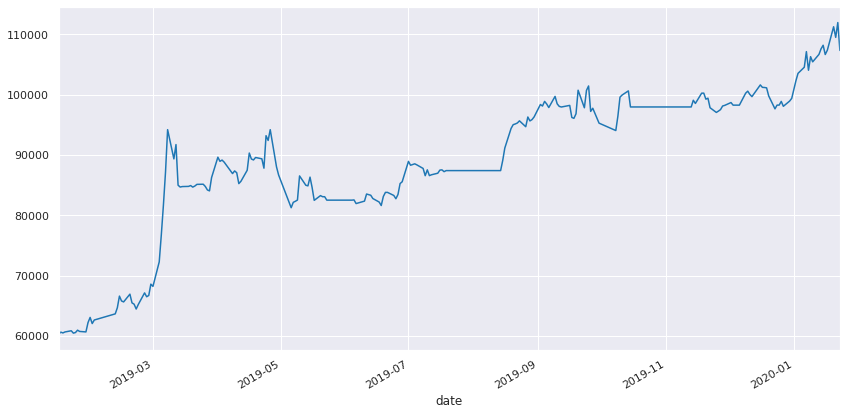

In [12]:

    holdingperc = 3
    safeholding = 500
    print('*' * 100)
    print('loading data')
    # stockes = getStocklist()
    # stockes = ['600797','000977']
    # data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*' * 100)
    print('init account')
    Account = QA.QA_Account(user_cookie='eric', portfolio_cookie='eric',commission_coeff=0.0002)
    Broker = QA.QA_BacktestBroker()
    Account.reset_assets(60000)
    Account.account_cookie = 'ECAP'
    # codelist=['600797','000977','601068','601069','000977']
    # 云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist1.extend(clist2)
    clist1.extend(clist3)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist1))

    

    #QA.QA_fetch_get_stock_info(code)
    cl =['600745','000977','002241','000810','600476']
    cur =datetime.datetime.now()
    mon = str(cur.month)
    day = str(cur.day)

    if (re.match('[0-9]{1}', mon) and len(mon) == 1):
        mon = '0' + mon
    if (re.match('[0-9]{1}', day) and len(day) == 1):
        day = '0' + day
    #endtime = str(cur.year) + '-' + mon + '-' + day

    endtime = '2020-05-11'
    data = loadLocalData(cl, '2019-01-01', endtime)
    data = data.to_qfq()
    print('*' * 100)
    print('prepare data for back test')

    #ind = data.add_func(trendSingleNew)
    #ind = data.add_func(MACD_JCSC)
    ind = data.add_func(doubleAvgmin)
    #ind = data.add_func(doubleAvg)
    #ind = data.add_func(nineTurn)
    # ind=data.add_func(MACACalculate)
    #ind = data.add_func(EMAOP)
    #cur = datetime.datetime.now()
    #endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data_forbacktest = data.select_time('2019-01-01',endtime)

    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:

            daily_ind = ind.loc[item.index]
            
            if (daily_ind.single.iloc[0] == 1):
                print(daily_ind) 
                if ((Account.cash_available - safeholding) / (holdingperc * item.open[0]) > 100 
                    and not np.isnan(item.open[0]) and not np.isnan(item.close[0])):
                    print('generate order for {}'.format(item.code[0]))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / (holdingperc * item.open[0])),
                        # amount = 2000,
                        # amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                elif ((Account.cash_available - safeholding) / (item.open[0]) > 100 
                     and not np.isnan(item.open[0]) and not np.isnan(item.close[0])):
                    print('generate order {}'.format(item.code[0]))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / item.open[0]),
                        # amount = 2000,
                        # amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                # print(item.to_json()[0])
                
                
                
                if order:
                    # print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    # print(trade_mes)
                    order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                    print('*' * 100)
                    print(str(item.date[0]) + " buy " + item.code[0])
                    print (res)
                    print('done >>>>>>>>>>>>>>>>>>>>>>>>>')
            elif (daily_ind.single.iloc[0] == 3):
                if Account.sell_available.get(item.code[0], 0) > 0:
                    print('>' * 100)
                    print(str(item.date[0]) + " sell " + item.code[0])
                    # print(int(Account.sell_available.get(item.code[0], 0)))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],

                        amount=Account.sell_available.get(item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        #price=(item.close[0]+(item.high[0]-item.close[0])/2),
                        price=item.close[0],
                        order_model=QA.ORDER_MODEL.LIMIT,

                        #amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    if order:
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                # print(res)
        Account.settle()

    print('*' * 100)
    print('analyse account profit')
    Risk = QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct)
    print('winning ratio is {}'.format(winRatio(Account)))
    print(Account.history_table)




In [13]:
ac = Account.history_table

In [65]:
def doubleAvgmin(dd, short=5, long=15, freq='60min'):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    start = dd.index.get_level_values('date')[0].strftime(dayformate)
    end = dd.index.get_level_values('date')[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = [0]
    for i in range(1, len(dd)):
        temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==
                      dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:-1]
        tmp = sample[sample.index.get_level_values(index).strftime(dayformate) ==
                       dd.index.get_level_values(dayindex)[i-1].strftime(dayformate)][-1:].single[0]
        temp['sig']=temp.single.cumsum(axis=0)
        sig.append(temp.sig[-1]+tmp)
        '''
        if( len(temp.single)>=3 and temp.single[-2]>=4):
            sig.append(3)
        else:
            sig.append(temp.single[-2])
        '''

    dd['single']=sig
    return dd

In [80]:
#!/usr/bin/python
# _*_ coding: UTF-8 _*_
import datetime
import smtplib
from email.mime.text import MIMEText
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
read_dictionary = np.load('/media/sf_GIT/vest/liutong.npy',allow_pickle=True).item()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_finance as mpf




class strategy:
    def __init__(self,df):
        self.sample = df
        self.sample['EMA12'] = QA.EMA(df.close, 12)
        self.sample['EMA5'] = QA.EMA(df.close, 5)
        self.sample['MA64'] = QA.MA(df.close, 64)
        self.sample['MA256'] = QA.MA(df.close, 256)
        self.sample['EMA30'] = QA.EMA(df.close, 30)
        self.sample['EMA13'] = QA.EMA(df.close, 13)
        self.sample['optimism'] = self.sample.high - self.sample.EMA13
        self.sample['pessmist'] = self.sample.low - self.sample.EMA13
        quotes = []
        N = self.sample.shape[0]
        ind = np.arange(N)
        for i in range(len(self.sample)):
            li = []
            # datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
            # datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d'))
            datef = ind[i]  # 日期转换成float days
            open_p = self.sample.open[i]
            close_p = self.sample.close[i]
            high_p = self.sample.high[i]
            low_p = self.sample.low[i]
            li = [datef, open_p, close_p, high_p, low_p]
            t = tuple(li)
            quotes.append(t)
        self.qots = quotes
    def addSingle(self):
        self.sample['single']=[0]*self.sample.shape[0]
        
    def plot(self,index,formate):
        N = self.sample.shape[0]
        ind = np.arange(N)

        def format_date(x, pos=None):
            thisind = np.clip(int(x + 0.5), 0, N - 1)
            return self.sample.index.get_level_values(index)[thisind].strftime(formate)

        fig = plt.figure()
        fig.set_size_inches(40.5, 20.5)
        ax2 = fig.add_subplot(211)
        ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')
        mpf.candlestick_ochl(ax2, self.qots, width=0.6, colorup='r', colordown='g', alpha=1.0)
        ax2.plot(ind, self.sample.MA64, 'red', label='MA64')
        ax2.plot(ind, self.sample.MA256, 'blue', label='MA256')
        
        for i in range(N):
            if (self.sample.single[i] == 1):
                ax2.axvline(x=i, ls='--', color='red')
            if (self.sample.single[i] == 3):
                ax2.axvline(x=i, ls='--', color='green')
        
        ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
        
        ax2.grid(True)
        ax2.legend(loc='best')
        fig.autofmt_xdate()
        #code = self.sample.index.get_level_values('code')[0]
        # plt.savefig('/home/mildone/monitor/'+'Trend'+code+'.png')
        
        ax1 = fig.add_subplot(222)
        ax1.set_title("candlestick", fontsize='xx-large', fontweight='bold')
        mpf.candlestick_ochl(ax2, self.qots, width=0.6, colorup='r', colordown='g', alpha=1.0)
        ax1.plot(ind, self.sample.MA64, 'red', label='MA64')
        ax1.plot(ind, self.sample.MA256, 'blue', label='MA256')
        
        
        ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
        
        ax1.grid(True)
        ax1.legend(loc='best')
        fig.autofmt_xdate()
        #code = self.sample.index.get_level_values('code')[0]
        # plt.savefig('/home/mildone/monitor/'+'Trend'+code+'.png')
        plt.show()
        plt.close()





In [6]:
dd = QA.QA_fetch_stock_day_adv('000977','2019-05-01','2020-05-01')
day = dd.data


In [7]:
import quant.weekTrend as wt

In [8]:
wd = wt.weekDF(day)
wd = wt.weektrend(wd)


In [9]:
end = day.index.get_level_values('date')[-1]


In [10]:
import dateutil
def getWeekDate(daytime):
    #daytime will be pandas datetime
    #return Timestamp('2020-05-11 00:00:00')
    return daytime+dateutil.relativedelta.relativedelta(days=(6-daytime.dayofweek))

In [11]:
m = getWeekDate(end)

In [29]:
import quant.Util as uti
wd[wd.date==m.strftime(uti.dayformate)].index[0]

51

In [33]:
wd.loc[51].MACDBlock

-0.6576548322899032

In [35]:
test = QA.QA_fetch_stock_day_adv('000977','2019-05-01','2020-06-08').data

In [37]:
import quant.nineTurn as nt 
nt.TrendTunel(test)

,,open,high,low,close,volume,amount,highEMAS25,lowEMAS25,Stunel,highEMAL90,lowEMAL90,EMA13,hold,trend,amountRatio
date,code,,,,,,,,,,,,,,,
2019-05-06,000977,24.16,24.68,22.94,22.94,850734.0,2.0062e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,1.3858
2019-05-07,000977,23.37,23.87,22.77,23.36,600942.0,1.4005e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,0.9674
2019-05-08,000977,22.75,24.30,22.50,23.44,642837.0,1.5153e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,1.0467
2019-05-09,000977,23.25,24.05,23.18,23.54,496603.0,1.1733e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,0.8105
2019-05-10,000977,23.80,25.44,23.28,25.18,874685.0,2.1455e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,1.4821
2019-05-13,000977,24.59,25.00,24.41,24.56,487930.0,1.2043e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,0.8319
2019-05-14,000977,24.60,24.95,24.40,24.52,436761.0,1.0764e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,0.7435
2019-05-15,000977,24.80,25.20,24.55,25.10,491392.0,1.2226e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,0.8445
2019-05-16,000977,25.03,25.03,24.20,24.41,490475.0,1.2005e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,2.8559,0.8293


In [82]:
test = strategy(day)
test.addSingle()

In [83]:
class macdStrategy(strategy):
    def __init__(self,df):
        super().__init__(df)
    def plotmacd(self,index,formate):
        super().plot(index,formate)

    def applySingle(self,short = 5,long =15,freq='60min'):
        """
         1.DIF向上突破DEA，买入信号参考。
         2.DIF向下跌破DEA，卖出信号参考。
         """
        dd=self.sample
        dayindex = uti.dayindex
        dayformate = uti.dayformate
        start = dd.index.get_level_values(dayindex)[0].strftime(dayformate)
        end = dd.index.get_level_values(dayindex)[-1].strftime(dayformate)
        mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
        sample = mindata.data
        # print(sample)
        sample['short'] = QA.EMA(sample.close, short)
        sample['long'] = QA.EMA(sample.close, long)
        CROSS_5 = QA.CROSS(sample.short, sample.long)
        CROSS_15 = QA.CROSS(sample.long, sample.short)

        C15 = np.where(CROSS_15 == 1, 3, 0)
        m = np.where(CROSS_5 == 1, 1, C15)
        # single = m[:-1].tolist()
        # single.insert(0, 0)
        sample['single'] = m.tolist()
        sig = [0]
        for i in range(1, len(dd)):

            temp = sample[sample.index.get_level_values(uti.index).strftime(dayformate) ==
                          dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:-1]
                # print(temp.shape[0])
            tmp = sample[sample.index.get_level_values(uti.index).strftime(dayformate) ==
                         dd.index.get_level_values(dayindex)[i - 1].strftime(dayformate)][-1:].single[0]
            temp['sig'] = temp.single.cumsum()
            sig.append(temp.sig[-1] + tmp)

        try:
            self.sample['single'] = sig

        except:
            print('error with {}'.format(sample.index.get_level_values('code')[0]))
            self.sample['single'] = 0

        


In [84]:
m = macdStrategy(day)

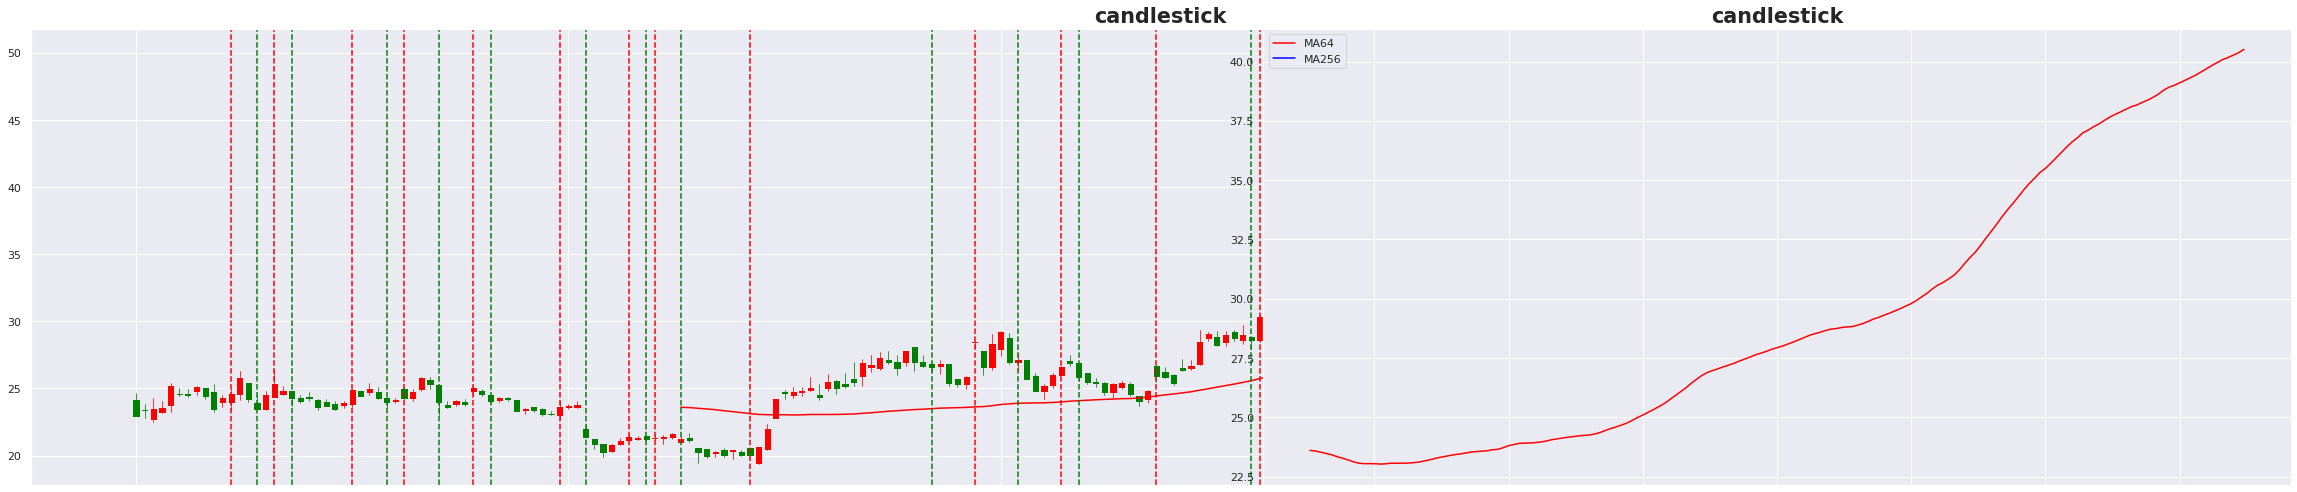

In [85]:
m.applySingle()
m.plotmacd(uti.dayindex,uti.dayformate)



QUANTAXIS>> No handles with labels found to put in legend.
No handles with labels found to put in legend.


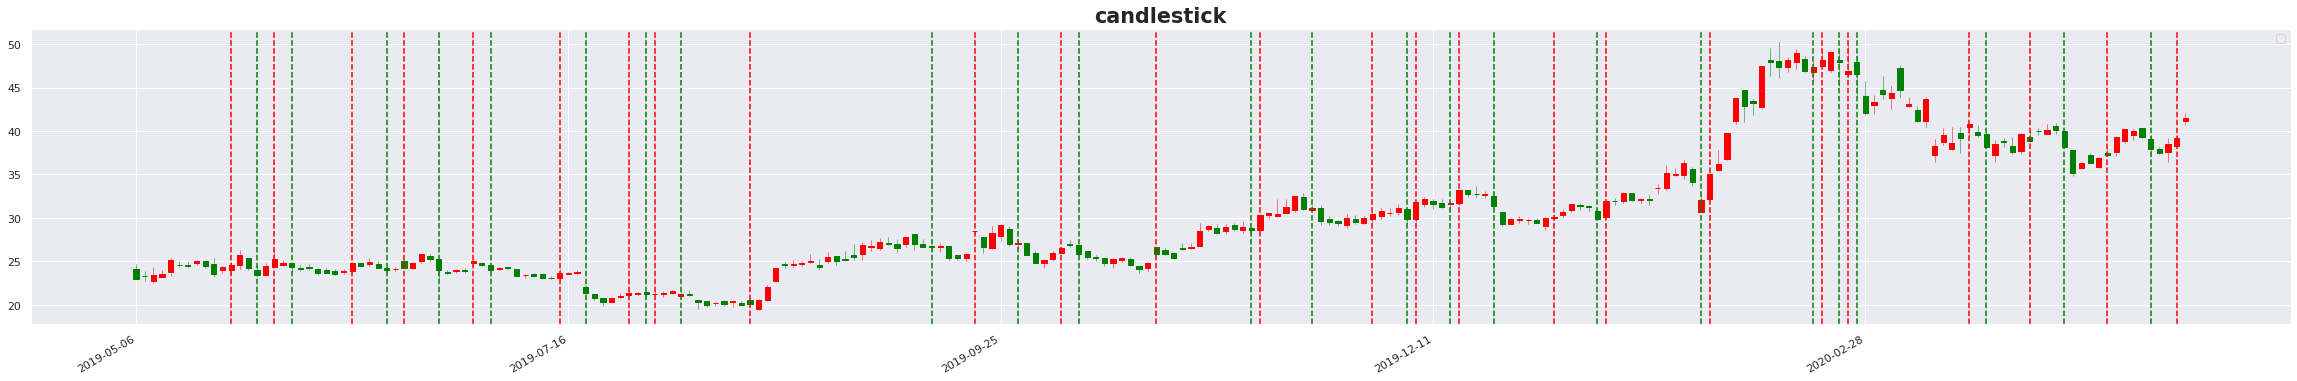

In [75]:
    quotes = macd.MINcandlestruct(day, uti.dayindex, uti.dayformate)
    #N = sample.index.get_level_values(index).shape[0]
    N = day.shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return day.index.get_level_values('date')[thisind].strftime(uti.dayformate)

    fig = plt.figure()
    fig.set_size_inches(40.5, 20.5)
    # plt.xlabel('Trading Day')
    # plt.ylabel('MACD EMA')
    #ax2 = fig.add_subplot(6, 1, 1)
    ax2 = fig.add_subplot(3,1,1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')

    # fig,ax=plt.subplots()
    # mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    # ax2.xaxis_date()
    # plt.setp(plt.gca().get_xticklabels(),rotation=30)
    # ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)
   
    for i in range(N):
        if(day.single[i]==1):
            ax2.axvline(x=i,ls='--',color='red')
        if(day.single[i]==3):
            ax2.axvline(x=i,ls='--',color='green')
    #ax2.plot(ind,sample.EMA20,'green')
    #ax2.plot(ind,sample.EMA30,'purple')
    #ax2.plot(ind,sample.nhigh)
    #ax2.plot(ind,sample.nlow)
   # ax2.fill_between(ind,sample.EMA13,color='blue',alpha=0.08)

    #ax2.text(N / 2, pd.DataFrame.max(sample.high), "EMA13 tells the trend",
    #         fontdict={'size': '12', 'color': 'b'})
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    # ax2.set_xticklabels(sample.index.get_level_values(index)[::3])
    ax2.grid(True)
    ax2.legend(loc='best')
    fig.autofmt_xdate()

In [57]:
temp1 = sample[sample.index.get_level_values(index).strftime(dayformate) ==
                      dd.index.get_level_values(dayindex)[-2].strftime(dayformate)][-1:].open[0]
temp1

20.27

In [136]:
day = QA.QA_fetch_stock_day_adv('000977','2019-01-01','2020-05-20')

In [137]:
def dayshift(day):
    sample = day.data
    sample['short']=QA.EMA(sample.close,5)
    sample['long']=QA.EMA(sample.close,15)

    CROSS_5 = QA.CROSS(sample.short, sample.long)
    sample['gold']=CROSS_5.tolist()
    CROSS_15 = QA.CROSS(sample.long, sample.short)
    sample['dead']=CROSS_15.tolist()

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
        #only can buytomorrow, so shift single
    single = [0] + m[:-1].tolist()
    
    sample['single'] = single
    return sample
    #sample['single']=m.tolist()


In [141]:
def doubleAvgmin(dd, short=5, long=15, freq='60min'):

    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    #init_trend(dd,15)
    #dd['MA60'] = QA.MA(dd.close, 60)
    start = dd.index.get_level_values(dayindex)[0].strftime(dayformate)
    dd['short']= QA.EMA(dd.close,short)
    dd['long']= QA.EMA(dd.close,long)
    end = dd.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['MA60'] = QA.MA(sample.close,60)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = [0]
    for i in range(1, len(dd)):
        temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:-1]
            #print(temp.shape[0])
        tmp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i-1].strftime(dayformate)][-1:].single[0]
        temp['sig']=temp.single.cumsum()
        sig.append(temp.sig[-1]+tmp)

        '''
        if( len(temp.single)>=3 and temp.single[-2]>=4):
            sig.append(3)
        else:
            sig.append(temp.single[-2])
        '''

    try:
        dd['single'] = sig

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single'] = 0

    return dd


In [160]:
def plot(sample):
    N = sample.shape[0]
    ind = np.arange(N)
    import quant.MACD as macd
    quotes = macd.MINcandlestruct(sample, uti.dayindex, uti.dayformate)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return sample.index.get_level_values(uti.dayindex)[thisind].strftime(uti.dayformate)

    fig = plt.figure()
    fig.set_size_inches(40.5, 20.5)
    ax2 = fig.add_subplot(111)
    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)
    ax2.plot(ind,sample.short,'r-',label='short')
    ax2.plot(ind,sample.long,'blue',label='long')
    for i in range(N):
        ax2.axvline(x=i,ls='--',color='white')
        if sample.single[i]==1:
            #ax2.axvline(x=i,ls='--',color='red')
            c1 = plt.Circle((i,sample.short[i]),0.3,color='black')
            ax2.add_artist(c1)
        if sample.single[i]==3:
            c2 = plt.Circle((i,sample.short[i]),0.3,color='blue')
            ax2.add_artist(c2)
            
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.grid(True)
    ax2.legend(loc='best')
    fig.autofmt_xdate()
    fig.show()

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


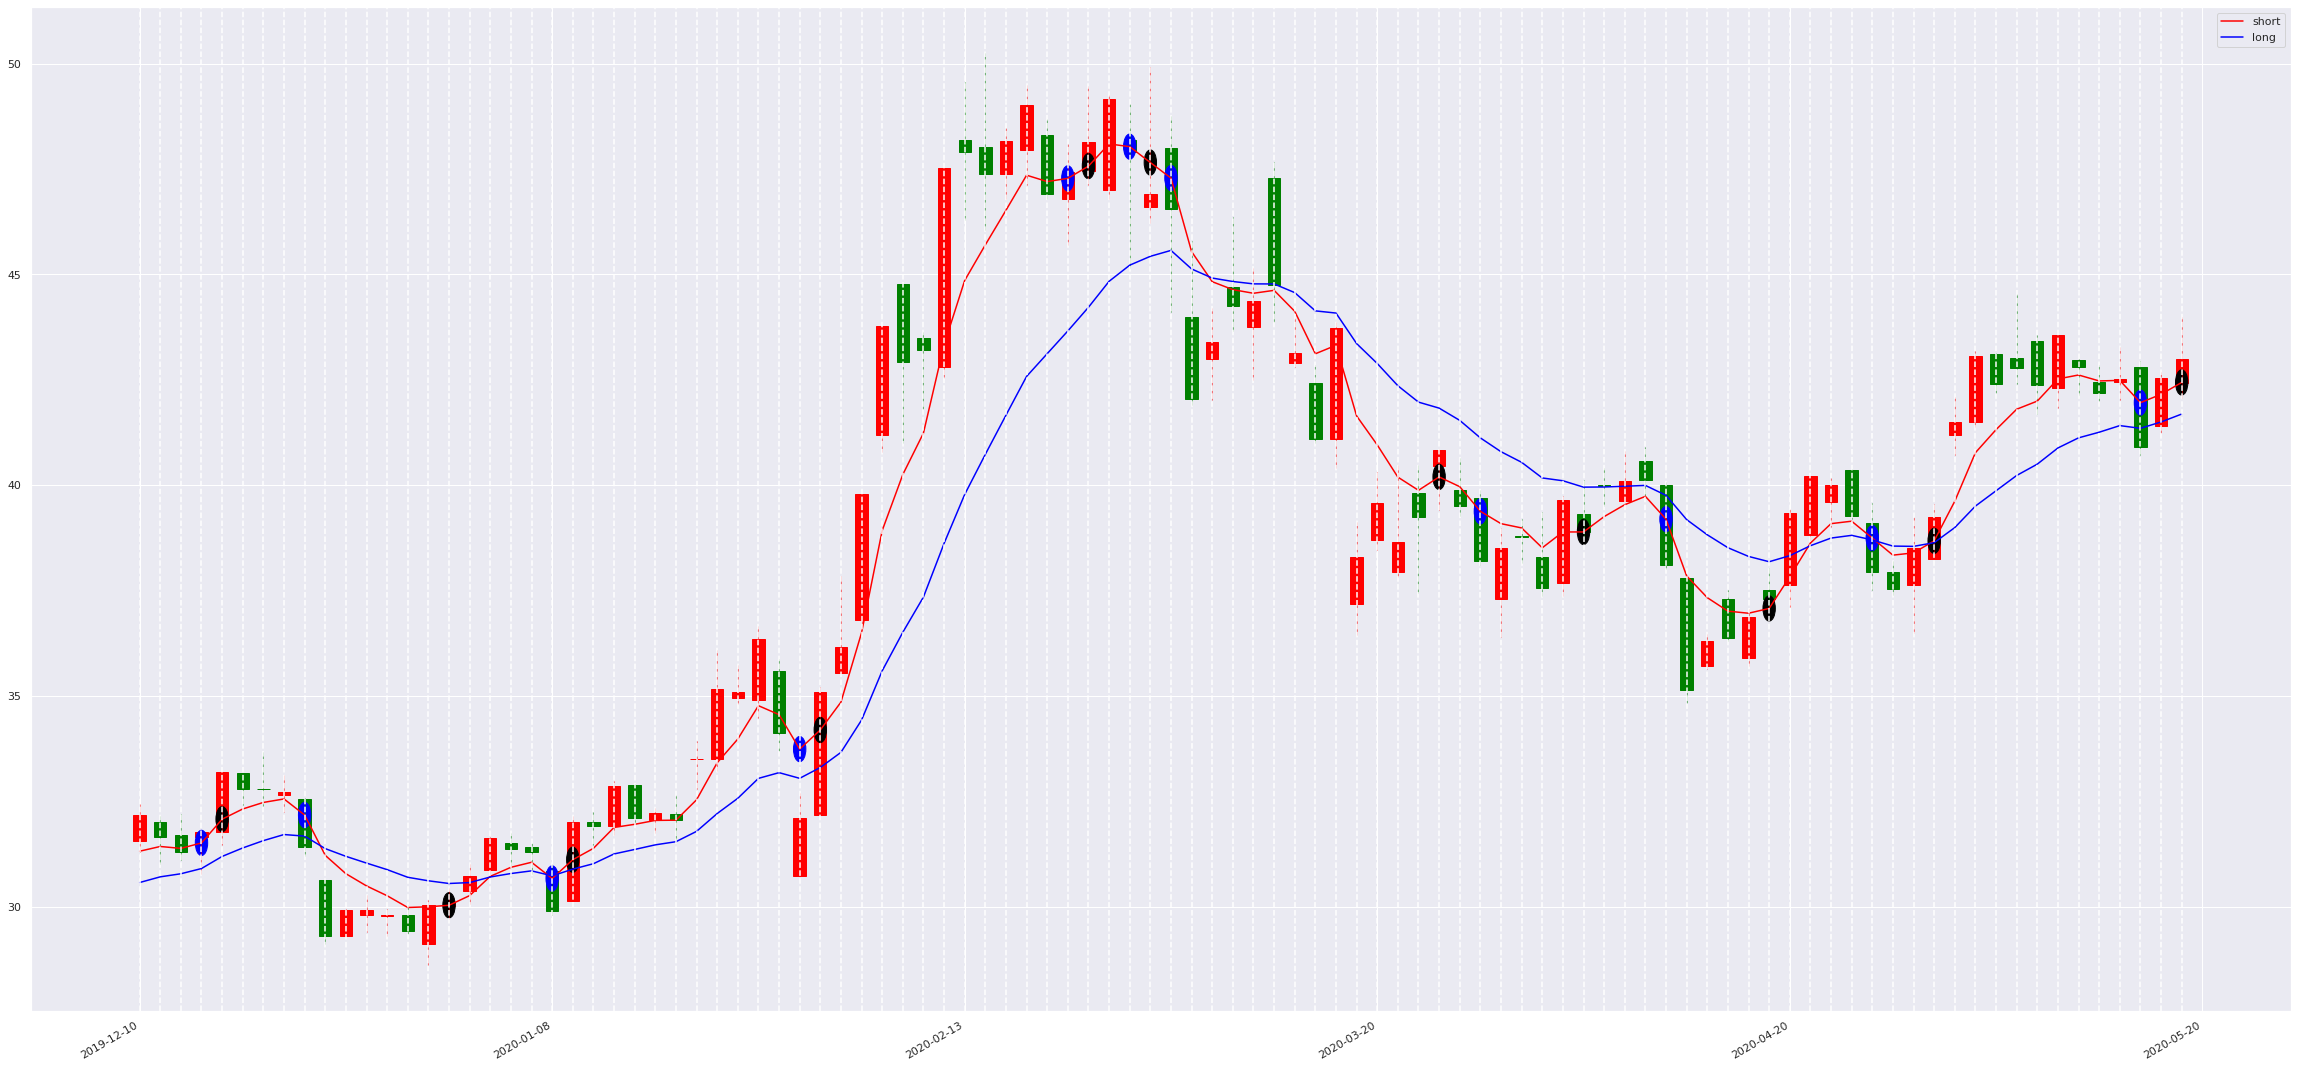

In [161]:
sample = doubleAvgmin(day.data)
plot(sample[-100:])

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


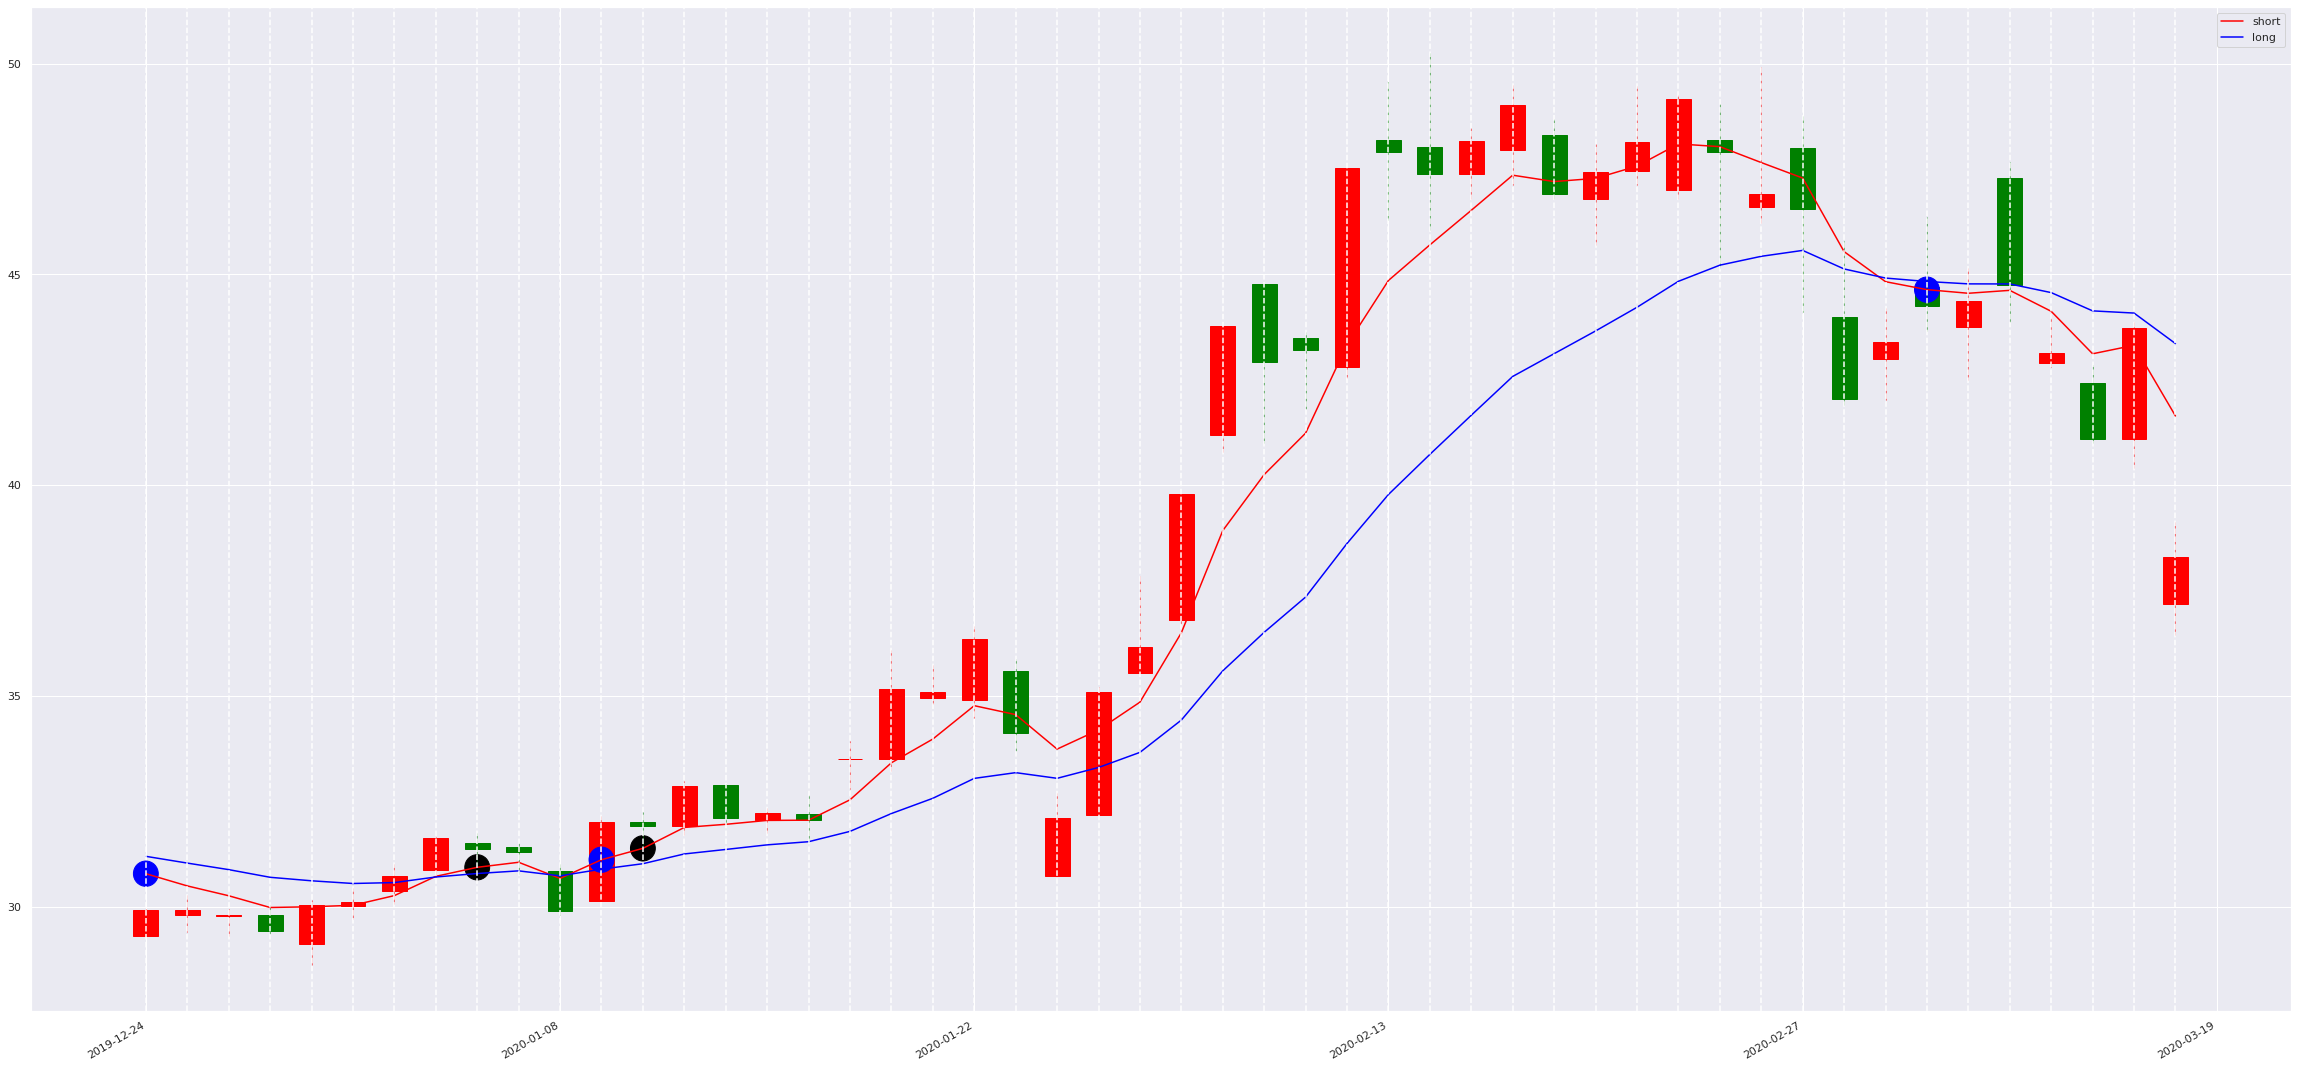

In [182]:
test =  dayshift(day)
plot(test[-90:-40])

In [183]:
test = day.data
import quant.Util as uti
uti.init_trend(test)
test[-90:-40]

,,open,high,low,close,volume,amount,single,short,long,gold,dead,trend,amountRatio
date,code,,,,,,,,,,,,,
2019-12-24,000977,29.30,29.95,29.30,29.91,312474.0,9.2728e+08,3,30.7800,31.1919,0,0,-6.7453,0.6183
2019-12-25,000977,29.80,30.28,29.40,29.91,340897.0,1.0166e+09,0,30.4900,31.0317,0,0,-6.6741,0.7457
2019-12-26,000977,29.78,29.95,29.30,29.79,321944.0,9.5323e+08,0,30.2566,30.8765,0,0,-6.0265,0.7680
2019-12-27,000977,29.79,30.03,29.36,29.42,275319.0,8.1784e+08,0,29.9778,30.6944,0,0,-4.7017,0.6674
2019-12-30,000977,29.10,30.16,28.61,30.03,305483.0,9.0624e+08,0,29.9952,30.6114,0,0,-1.5714,0.8205
2019-12-31,000977,30.01,30.45,29.71,30.10,255244.0,7.6952e+08,0,30.0301,30.5474,0,0,0.8770,0.8326
2020-01-02,000977,30.38,31.00,30.07,30.72,320889.0,9.8452e+08,0,30.2601,30.5690,0,0,1.2190,1.1029
2020-01-03,000977,30.86,31.65,30.71,31.63,387058.0,1.2092e+09,0,30.7167,30.7016,1,0,2.9889,1.3644
2020-01-06,000977,31.50,31.75,30.93,31.36,333653.0,1.0451e+09,1,30.9311,30.7839,0,0,3.8118,1.1148


In [94]:
def resampleMin(dd, short=5, long=15,freq='60min'):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    start = dd.index.get_level_values('date')[0].strftime('%Y-%m-%d')
    end = dd.index.get_level_values('date')[-1].strftime('%Y-%m-%d')
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0],start,end, frequence= freq)
    sample =mindata.data
    #print(sample)
    sample['short']=QA.EMA(sample.close,short)
    sample['long']=QA.EMA(sample.close,long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    #single = m[:-1].tolist()
    #single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = []
    for i in range(0, len(dd)):
        temp = sample[sample.index.get_level_values(uti.index).strftime(uti.dayformate)==dd.index.get_level_values(uti.dayindex)[i].strftime(uti.dayformate)]
        temp['single'].cumsum(axis=0)
        sig.append( temp.single[-2]) 
    
    try:
        dd['single'] = sig
    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single']=0

    return dd


In [86]:
test = [0]

In [102]:
m = [ 1,2,3,4,5]


In [103]:
dd = 


In [104]:
n


[0, 1, 2, 3, 4]

In [28]:
ti = sample.index.get_level_values('date')[1]




In [32]:
ti.day_name

Timestamp('2020-01-03 00:00:00')

In [33]:
ti.isoformat

<bound method Timestamp.isoformat of Timestamp('2020-01-03 00:00:00')>

In [39]:
import dateutil as du

In [42]:
ti-du.relativedelta.relativedelta(days=4)

Timestamp('2019-12-30 00:00:00')

In [102]:
sample = QA.QA_fetch_stock_day_adv('600745','2019-01-01','2020-05-11').data

In [103]:
def weekDF(df):
    df.reset_index(inplace=True)
    df.drop(['code'],axis=1,inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index("date", inplace=True)
    period = 'W'
    weekly_df = df.resample(period).last()
    weekly_df['open'] = df['open'].resample(period).first()
    weekly_df['high'] = df['high'].resample(period).max()
    weekly_df['low'] = df['low'].resample(period).min()
    weekly_df['close'] = df['close'].resample(period).last()
    weekly_df['volume'] = df['volume'].resample(period).sum()
    weekly_df['amount'] = df['amount'].resample(period).sum()
    weekly_df.reset_index('date',inplace=True)
    return weekly_df

In [104]:
wf = weekDF(sample)

In [106]:
wf

,date,open,high,low,close,volume,amount
0,2019-01-06,21.45,21.48,19.00,20.58,222311.0,4.4541e+08
1,2019-01-13,21.00,22.04,20.30,20.47,242598.0,5.0725e+08
2,2019-01-20,20.44,20.44,19.22,19.30,203920.0,4.0123e+08
3,2019-01-27,19.16,22.22,17.71,20.64,460580.0,9.1782e+08
4,2019-02-03,20.43,22.59,20.38,22.59,335070.0,7.1575e+08
5,2019-02-10,NaN,NaN,NaN,NaN,0.0,0.0000e+00
6,2019-02-17,23.25,26.62,22.46,26.25,483052.0,1.1839e+09
7,2019-02-24,26.30,27.20,25.03,26.42,520608.0,1.3625e+09
8,2019-03-03,26.98,30.90,26.96,29.14,414445.0,1.2127e+09
9,2019-03-10,30.01,31.90,27.50,29.97,639741.0,1.9240e+09


In [107]:
sample

,open,high,low,close,volume,amount
date,,,,,,
2019-01-02,21.45,21.48,20.65,20.93,42123.0,8.8421e+07
2019-01-03,21.13,21.13,19.00,19.21,97539.0,1.9168e+08
2019-01-04,19.47,20.62,19.47,20.58,82649.0,1.6530e+08
2019-01-07,21.00,21.28,20.30,21.00,57175.0,1.1936e+08
2019-01-08,20.87,21.19,20.50,20.54,40583.0,8.4160e+07
2019-01-09,20.92,22.04,20.46,21.20,67745.0,1.4390e+08
2019-01-10,20.96,21.12,20.31,20.59,44279.0,9.1926e+07
2019-01-11,20.63,21.19,20.35,20.47,32816.0,6.7909e+07
2019-01-14,20.44,20.44,19.70,19.88,29325.0,5.8675e+07


In [108]:
ti = sample.index.get_level_values('date')[-1]

In [109]:
ti

Timestamp('2020-05-11 00:00:00')

In [110]:
m = ti+ du.relativedelta.relativedelta(days=(6-ti.dayofweek))

In [111]:
m

Timestamp('2020-05-17 00:00:00')

In [83]:
ti.dayofweek

2

In [92]:
wf[wf.date==m].index[0]

68